In [1]:
from IPython import *
from IPython.display import *


In [2]:
import math
import os
import sys


In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [4]:
import tensorflow as tf

import tensorflow.keras as keras
import tensorflow.keras.backend as K
import tensorflow.keras.callbacks as callbacks
import tensorflow.keras.layers as layers
import tensorflow.keras.losses as losses
import tensorflow.keras.metrics as metrics
import tensorflow.keras.optimizers as optimizers
import tensorflow.keras.utils as utils


2021-09-14 17:02:55.329628: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [5]:
import hyperopt as hopt


In [6]:
import delayed_early_stopping


In [7]:
data_root = 'data'
arrays_root = 'arrays'
models_root = 'models'


In [8]:
df = pd.read_csv(
    os.path.join(data_root, 'scores.csv'),
    sep = ';',
    header = 0,
    index_col = None,
    decimal = ','
)


In [9]:
labels = pd.read_csv(
    os.path.join(data_root, 'labels.csv'),
    sep = ';',
    header = 0,
    index_col = None,
    decimal = ','
)


In [10]:
df = df.merge(labels, how = 'left', on = 'country')


In [11]:
del labels


In [12]:
df = df[
    [
        'year',
        'country',
        'label',
        'score',
        'nscore',
        'rank',
        'weight'
    ]
].reset_index(drop = True).copy(deep = True)


In [13]:
R = np.random.default_rng(2021)


In [14]:
year = 2004


In [15]:
pc = np.load(os.path.join(models_root, str(year), 'wpca.npy'))


In [16]:
loc_T = np.load(os.path.join(arrays_root, str(year), 'loc_transform.npy'))
loc_year = np.load(os.path.join(arrays_root, str(year), 'loc_year.npy'))
loc_time = np.load(os.path.join(arrays_root, str(year), 'loc_time.npy'))
loc_pos = np.load(os.path.join(arrays_root, str(year), 'loc_pos.npy'))
loc_diverse = np.load(os.path.join(arrays_root, str(year), 'loc_diverse.npy'))
loc_score = np.load(os.path.join(arrays_root, str(year), 'loc_score.npy'))
scale_T = np.load(os.path.join(arrays_root, str(year), 'scale_transform.npy'))
scale_year = np.load(os.path.join(arrays_root, str(year), 'scale_year.npy'))
scale_time = np.load(os.path.join(arrays_root, str(year), 'scale_time.npy'))
scale_pos = np.load(os.path.join(arrays_root, str(year), 'scale_pos.npy'))
scale_diverse = np.load(os.path.join(arrays_root, str(year), 'scale_diverse.npy'))
scale_score = np.load(os.path.join(arrays_root, str(year), 'scale_score.npy'))


In [17]:
X_train = list()
year_train = list()
time_train = list()
pos_train = list()
diverse_train = list()
y_train = list()
weights_train = list()

X_valid = list()
year_valid = list()
time_valid = list()
pos_valid = list()
diverse_valid = list()
y_valid = list()
weights_valid = list()

for y in range(year - 10, year):
    trains = np.load(os.path.join(arrays_root, str(y), 'train.npy'))

    I = df.index[df.year == y]

    mid_rank = float(0.5 * (I.size - 1))

    for i in I:
        c = str(np.asarray(df.loc[i, 'country']).item())
        a = np.asarray(df.loc[i, 'year']).item()
        s = np.asarray(df.loc[i, 'nscore']).item()
        #s = (np.asarray(df.loc[i, 'rank']).item() <= mid_rank)
        w = np.asarray(df.loc[i, 'weight']).item()

        x = np.load(os.path.join(arrays_root, str(y), c, 'penultimate.npy'))
        t = np.load(os.path.join(arrays_root, str(y), c, 't.npy'))
        p = np.load(os.path.join(arrays_root, str(y), c, 'p.npy'))
        d = np.load(os.path.join(arrays_root, str(y), c, 'diverse.npy'))

        if np.asarray(df.loc[i, 'label']).item() in trains:
            X_train.append(x)
            year_train.append(np.full(x.shape[0], a, dtype = x.dtype))
            time_train.append(np.full(x.shape[0], t, dtype = x.dtype))
            pos_train.append(np.full(x.shape[0], p, dtype = x.dtype))
            diverse_train.append(np.full(x.shape[0], d, dtype = x.dtype))
            y_train.append(np.full(x.shape[0], s, dtype = x.dtype))
            weights_train.append(np.full(x.shape[0], w, dtype = x.dtype))
        else:
            X_valid.append(x)
            year_valid.append(np.full(x.shape[0], a, dtype = x.dtype))
            time_valid.append(np.full(x.shape[0], t, dtype = x.dtype))
            pos_valid.append(np.full(x.shape[0], p, dtype = x.dtype))
            diverse_valid.append(np.full(x.shape[0], d, dtype = x.dtype))
            y_valid.append(np.full(x.shape[0], s, dtype = x.dtype))
            weights_valid.append(np.full(x.shape[0], w, dtype = x.dtype))

        del x
        del t
        del p
        del d

        del c
        del a
        del s
        del w

    del mid_rank

    del I

    del trains

X_train = np.concatenate(X_train, axis = 0)
year_train = np.squeeze(np.concatenate(year_train, axis = 0))
time_train = np.squeeze(np.concatenate(time_train, axis = 0))
pos_train = np.squeeze(np.concatenate(pos_train, axis = 0))
diverse_train = np.squeeze(np.concatenate(diverse_train, axis = 0))
y_train = np.squeeze(np.concatenate(y_train, axis = 0))
weights_train = np.squeeze(np.concatenate(weights_train, axis = 0))
weights_train = X_train.shape[0] / math.fsum(weights_train) * weights_train

X_valid = np.concatenate(X_valid, axis = 0)
year_valid = np.squeeze(np.concatenate(year_valid, axis = 0))
time_valid = np.squeeze(np.concatenate(time_valid, axis = 0))
pos_valid = np.squeeze(np.concatenate(pos_valid, axis = 0))
diverse_valid = np.squeeze(np.concatenate(diverse_valid, axis = 0))
y_valid = np.squeeze(np.concatenate(y_valid, axis = 0))
weights_valid = np.squeeze(np.concatenate(weights_valid, axis = 0))
weights_valid = X_valid.shape[0] / math.fsum(weights_valid) * weights_valid


In [18]:
n_components = 24


In [19]:
in_train = np.concatenate(
    (
        np.dot(X_train, pc)[:, :n_components],
        np.expand_dims(year_train, axis = 1),
        np.expand_dims(time_train, axis = 1),
        np.expand_dims(pos_train, axis = 1),
        np.expand_dims(diverse_train, axis = 1)
    ),
    axis = 1
)
in_valid = np.concatenate(
    (
        np.dot(X_valid, pc)[:, :n_components],
        np.expand_dims(year_valid, axis = 1),
        np.expand_dims(time_valid, axis = 1),
        np.expand_dims(pos_valid, axis = 1),
        np.expand_dims(diverse_valid, axis = 1)
    ),
    axis = 1
)
loc_in = np.concatenate(
    (
        loc_T[:, :n_components],
        [[loc_year.item()]],
        [[loc_time.item()]],
        [[loc_pos.item()]],
        [[loc_diverse.item()]]
    ),
    axis = 1
)
scale_in = np.concatenate(
    (
        scale_T[:, :n_components],
        [[scale_year.item()]],
        [[scale_time.item()]],
        [[scale_pos.item()]],
        [[scale_diverse.item()]]
    ),
    axis = 1
)

out_train = y_train
out_valid = y_valid
loc_out = loc_score
scale_out = scale_score


In [20]:
n_in = loc_in.shape[1]
n_out = loc_out.size


In [21]:
adjusted_in_train = (in_train - loc_in) / scale_in
adjusted_out_train = (out_train - loc_out) / scale_out

adjusted_in_valid = (in_valid - loc_in) / scale_in
adjusted_out_valid = (out_valid - loc_out) / scale_out


In [22]:
batch_size = 256
n_epochs = 256
early_stopping = 32
early_stopping_delay = 32
max_learning_rate = 5.0e-2
max_lr_patience = 4


In [23]:
max_hidden_layers = 4
max_n_units = 42


In [24]:
inner_trials = 4
outer_trials = 50

inner_quantile = 0.75


In [25]:
def objective (space):
    if (
        space['hidden_layers'] < 0 or
        space['hidden_layers'] > max_hidden_layers or
        any(
            (
                space[f"n_units_{i + 1:d}"] < 1 or
                space[f"n_units_{i + 1:d}"] > max_n_units
            ) for i in range(int(round(space['hidden_layers'])))
        ) or
        space['learning_rate'] <= 0 or
        (
            space['reduce_lr_on_plateau'] and
            (
                space['lr_patience'] < 1 or
                space['lr_factor'] <= 0 or
                space['lr_factor'] >= 1
            )
        )
    ):
        return { 'status': hopt.STATUS_FAIL }

    loss = list()
    val_loss = list()

    for i in range(inner_trials):
        inputs = layers.Input(
            shape = n_in,
            name = 'input'
        )
        outputs = inputs
        for i in range(int(round(space['hidden_layers']))):
            outputs = layers.Dense(
                units = int(round(space[f"n_units_{i + 1:d}"])),
                activation = 'relu',
                name = f"hidden_{i + 1:d}"
            )(outputs)
        outputs = layers.Dense(
            units = n_out,
            activation = 'linear',
            name = 'output'
        )(outputs)

        model = keras.Model(
            inputs = inputs,
            outputs = outputs,
            name = 'model'
        )

        del inputs
        del outputs

        model.compile(
            optimizer = optimizers.Adadelta(
                learning_rate = float(space['learning_rate'])
            ),
            loss = 'mean_squared_error',
            metrics = None
        )

        cb = [
            callbacks.TerminateOnNaN(),
            delayed_early_stopping.DelayedEarlyStopping(
                delay = early_stopping_delay,
                monitor = 'val_loss',
                patience = early_stopping,
                mode = 'min',
                restore_best_weights = True
            )
        ]
        if space['reduce_lr_on_plateau']:
            cb.append(
                callbacks.ReduceLROnPlateau(
                    monitor = 'val_loss',
                    patience = int(round(space['lr_patience'])),
                    mode = 'min',
                    factor = float(space['lr_factor'])
                )
            )

        history = model.fit(
            x = adjusted_in_train,
            y = adjusted_out_train,
            sample_weight = weights_train,
            validation_data = (
                adjusted_in_valid,
                adjusted_out_valid,
                weights_valid
            ),
            shuffle = True,
            batch_size = 256,
            epochs = n_epochs,
            verbose = 0,
            use_multiprocessing = False,
            callbacks = cb
        )

        del cb

        this_loss = np.asarray(history.history['loss'])
        this_val_loss = np.asarray(history.history['val_loss'])

        del history

        del model

        if np.any(np.isnan(loss)) or np.any(np.isnan(val_loss)):
            return { 'status': hopt.STATUS_FAIL }

        loss.append(np.amin(this_loss))
        val_loss.append(np.amin(this_val_loss))

        del this_loss
        del this_val_loss

    return {
        'status': hopt.STATUS_OK,
        'loss': np.quantile(val_loss, q = inner_quantile)
    }


In [26]:
hp_space = {
    'hidden_layers': hopt.hp.randint('hidden_layers', max_hidden_layers + 1),
    'learning_rate': hopt.hp.uniform('learning_rate', 0, max_learning_rate),
    'reduce_lr_on_plateau': hopt.hp.choice(
        'reduce_lr_on_plateau',
        [ False, True ]
    ),
    'lr_patience': 1 + hopt.hp.randint('lr_patience', max_lr_patience),
    'lr_factor': hopt.hp.uniform('lr_factor', 0, 1)
}
for i in range(max_hidden_layers):
    hp_space.update(
        {
            f"n_units_{i + 1:d}": \
                1 + hopt.hp.randint(f"n_units_{i + 1:d}", max_n_units)
        }
    )


In [27]:
trials = hopt.Trials()
best_hp = hopt.fmin(
    objective,
    space = hp_space,
    algo = hopt.tpe.suggest,
    max_evals = outer_trials,
    trials = trials
)


  0%|                                    | 0/50 [00:00<?, ?trial/s, best loss=?]

2021-09-14 17:03:02.981498: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-09-14 17:03:03.038229: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-14 17:03:03.039656: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 950M computeCapability: 5.0
coreClock: 0.928GHz coreCount: 5 deviceMemorySize: 1.96GiB deviceMemoryBandwidth: 74.65GiB/s
2021-09-14 17:03:03.039836: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-09-14 17:03:03.053232: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-09-14 17:03:03.053440: I tensorflow/stream_executor/platf

100%|█████████| 50/50 [14:33<00:00, 17.46s/trial, best loss: 1.3866616785526276]


In [28]:
best_hp


{'hidden_layers': 4,
 'learning_rate': 0.03888063434715749,
 'lr_factor': 0.5748885228251721,
 'lr_patience': 3,
 'n_units_1': 4,
 'n_units_2': 35,
 'n_units_3': 16,
 'n_units_4': 32,
 'reduce_lr_on_plateau': 0}

In [29]:
inputs = layers.Input(
    shape = n_in,
    name = 'input'
)
outputs = inputs
for i in range(int(round(best_hp['hidden_layers']))):
    outputs = layers.Dense(
        units = int(round(best_hp[f"n_units_{i + 1:d}"])),
        activation = 'relu',
        name = f"hidden_{i + 1:d}"
    )(outputs)
outputs = layers.Dense(
    units = n_out,
    activation = 'linear',
    name = 'output'
)(outputs)

model = keras.Model(
    inputs = inputs,
    outputs = outputs,
    name = 'model'
)

display(model.summary())


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28)]              0         
_________________________________________________________________
hidden_1 (Dense)             (None, 4)                 116       
_________________________________________________________________
hidden_2 (Dense)             (None, 35)                175       
_________________________________________________________________
hidden_3 (Dense)             (None, 16)                576       
_________________________________________________________________
hidden_4 (Dense)             (None, 32)                544       
_________________________________________________________________
output (Dense)               (None, 1)                 33        
Total params: 1,444
Trainable params: 1,444
Non-trainable params: 0
___________________________________________________________

None

In [30]:
model.compile(
    optimizer = optimizers.Adadelta(
        learning_rate = float(best_hp['learning_rate'])
    ),
    loss = 'mean_squared_error',
    metrics = None
)


In [31]:
cb = [
    callbacks.TerminateOnNaN(),
    delayed_early_stopping.DelayedEarlyStopping(
        delay = early_stopping_delay,
        monitor = 'val_loss',
        patience = early_stopping,
        mode = 'min',
        restore_best_weights = True
    )
]
if best_hp['reduce_lr_on_plateau']:
    cb.append(
        callbacks.ReduceLROnPlateau(
            monitor = 'val_loss',
            patience = int(round(best_hp['lr_patience'])),
            mode = 'min',
            factor = float(best_hp['lr_factor'])
        )
    )

history = model.fit(
    x = adjusted_in_train,
    y = adjusted_out_train,
    sample_weight = weights_train,
    validation_data = (
        adjusted_in_valid,
        adjusted_out_valid,
        weights_valid
    ),
    shuffle = True,
    batch_size = 256,
    epochs = n_epochs,
    verbose = 0,
    use_multiprocessing = False,
    callbacks = cb
)

del cb


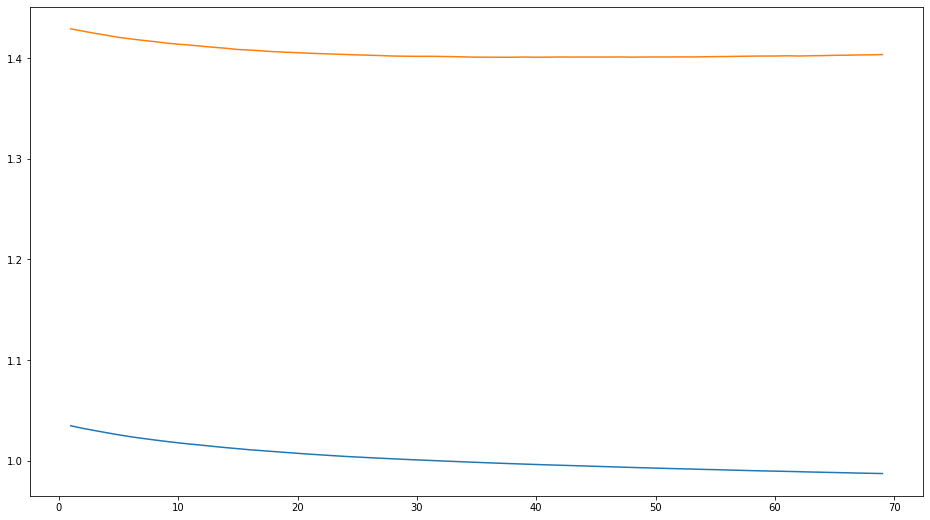

In [32]:
k = len(history.history['loss'])

fig = plt.figure(figsize = (16, 9))

ax = fig.add_subplot(111)

ax.plot(
    list(range(1, k + 1)),
    history.history['loss'][:k]
)
ax.plot(
    list(range(1, k + 1)),
    history.history['val_loss'][:k]
)

plt.show()

del k


In [33]:
pred = list()

for y in range(year, year + 1):
    I = df.index[df.year == y]

    for i in I:
        X_test = list()
        year_test = list()
        time_test = list()
        pos_test = list()
        diverse_test = list()
        y_test = None

        c = str(np.asarray(df.loc[i, 'country']).item())
        a = np.asarray(df.loc[i, 'year']).item()
        s = np.asarray(df.loc[i, 'nscore']).item()
        #s = (np.asarray(df.loc[i, 'rank']).item() <= mid_rank)

        x = np.load(os.path.join(arrays_root, str(y), c, 'penultimate.npy'))
        t = np.load(os.path.join(arrays_root, str(y), c, 't.npy'))
        p = np.load(os.path.join(arrays_root, str(y), c, 'p.npy'))
        d = np.load(os.path.join(arrays_root, str(y), c, 'diverse.npy'))

        X_test.append(x)
        year_test.append(np.full(x.shape[0], a, dtype = x.dtype))
        time_test.append(np.full(x.shape[0], t, dtype = x.dtype))
        pos_test.append(np.full(x.shape[0], p, dtype = x.dtype))
        diverse_test.append(np.full(x.shape[0], d, dtype = x.dtype))
        y_test = x.dtype.type(s)

        del x
        del t
        del p
        del d

        del c
        del a
        del s

        X_test = np.concatenate(X_test, axis = 0)
        year_test = np.squeeze(np.concatenate(year_test, axis = 0))
        time_test = np.squeeze(np.concatenate(time_test, axis = 0))
        pos_test = np.squeeze(np.concatenate(pos_test, axis = 0))
        diverse_test = np.squeeze(np.concatenate(diverse_test, axis = 0))

        in_test = np.concatenate(
            (
                np.dot(X_test, pc)[:, :n_components],
                np.expand_dims(year_test, axis = 1),
                np.expand_dims(time_test, axis = 1),
                np.expand_dims(pos_test, axis = 1),
                np.expand_dims(diverse_test, axis = 1)
            ),
            axis = 1
        )

        out_test_pred = model.predict(
            (in_test - loc_in) / scale_in,
            batch_size = 64
        )

        y_test_pred = scale_out * out_test_pred + loc_out

        pred.append((y_test, y_test_pred))

        del y_test_pred

        del out_test_pred

        del in_test

        del X_test
        del year_test
        del time_test
        del pos_test
        del diverse_test
        del y_test

    del I


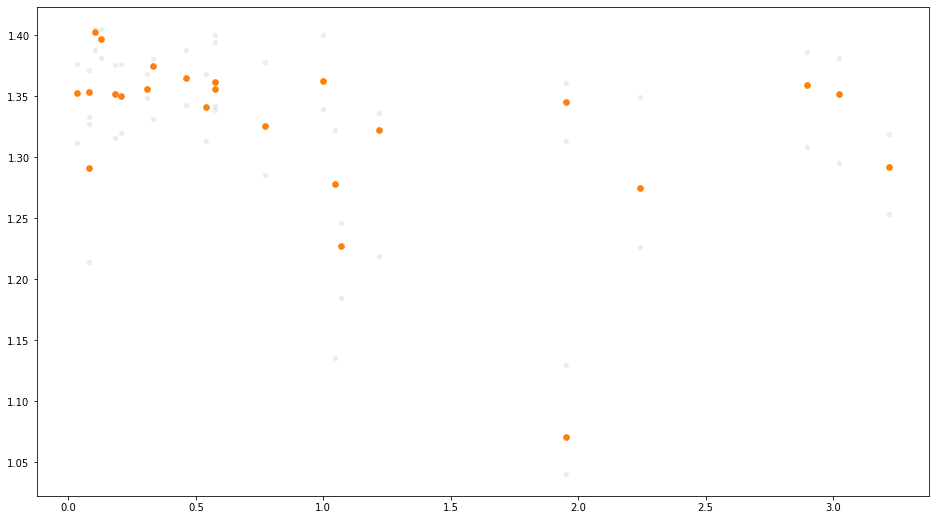

In [34]:
fig = plt.figure(figsize = (16, 9))

ax = fig.add_subplot(111)

ax.scatter(
    list(p[0] for p in pred),
    list(np.quantile(p[1], q = 0.25) for p in pred),
    color = 'C0',
    alpha = 0.1,
    s = 16
)
ax.scatter(
    list(p[0] for p in pred),
    list(np.quantile(p[1], q = 0.75) for p in pred),
    color = 'C2',
    alpha = 0.1,
    s = 16
)
ax.scatter(
    list(p[0] for p in pred),
    list(np.quantile(p[1], q = 0.5) for p in pred),
    color = 'C1',
    alpha = 1,
    s = 32
)

plt.show()
